# NGC7793 Bayesian Analysis

In this notebook, we define two different models that could fit our NGC7793 data via PyMC3 and SciPy. Then we compare both of them using LOO cross validation.
The data we'll use here is the temprature from the inner disk of the source (Th) and its luminosity (Luminosity_h). The same process has to be followed if we want to fit also the outer accretion disk.

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

In [2]:
%matplotlib inline
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.size'] = 13
#plt.rcParams['axes.labelsize'] = 10
#plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams['axes.titlesize'] = 10
#plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 17.0
plt.rcParams['axes.linewidth'] = 2

In [3]:
data=pd.read_csv('FluxData2_both.csv')

In [4]:
data

,ObsID,N(10^22),N error +,N error -,Flux_h,Flux_h error(+),Flux_h error(-),Th,Th error(+),Th error(-),Th norm,Flux_l,Flux_l error(+),Flux_l error(-),Tl,Tl error(+),Tl error(-),norm,chi
0,840990101,7.140250e-02,0.035406,-0.024934,-12.5640,0.030854,-0.047990,1.10216,0.107474,-0.078506,0.010626,-13.2673,0.135908,-0.178221,0.295654,0.108561,-0.065930,0.581529,"1,05708"
1,861600101,7.318010e-02,0.009927,-0.008817,-12.4330,0.029092,-0.032520,1.31900,0.100178,-0.084841,0.007340,-12.5329,0.027489,-0.029163,0.320509,0.023348,-0.022157,2.255190,"1,01374651810585"
2,804670201,1.104910e-01,0.083083,-0.056072,-12.8171,0.066348,-0.118795,1.12928,0.370526,-0.180918,0.004760,-13.1202,0.193440,-0.179782,0.253131,0.125285,-0.067812,0.947603,"0,655392156862745"
3,804670301,6.258270e-02,0.021677,-0.016314,-12.9084,0.098586,-0.159419,1.36936,0.459999,-0.226458,0.002198,-13.0576,0.135104,-0.148363,0.442339,0.107975,-0.099979,0.154482,"1,26406926406926"
4,804670401,1.030190e-01,0.070918,-0.047093,-12.6676,0.038708,-0.060247,1.09905,0.140392,-0.094517,0.008432,-13.2323,0.205213,-0.184404,0.247867,0.120368,-0.059472,1.590570,"0,987388535031847"
5,804670501,5.231130e-02,0.023476,-0.023126,-12.6095,0.026431,-0.028006,1.03894,0.078285,-0.071136,0.011963,-13.5777,0.243303,-0.538748,0.306613,0.000000,0.000000,0.251875,"0,867796610169492"
6,804670601,1.399510e-01,0.062138,-0.049599,-12.4832,0.027682,-0.030731,1.09388,0.078158,-0.067059,0.013134,-13.0761,0.206773,-0.199926,0.200773,0.056974,-0.033125,6.922450,"1,03276381909548"
7,823410401,7.336020e-02,0.021438,-0.015963,-11.8393,0.021582,-0.033335,1.55197,0.110783,-0.079142,0.016172,-12.6617,0.125399,-0.118363,0.372184,0.121191,-0.077656,0.832365,"0,972869565217391"
8,804670701,5.741360e-02,0.034986,-0.022407,-12.6026,0.074280,-0.168726,1.44068,0.743760,-0.245299,0.003728,-12.9947,0.221467,-0.185186,0.396319,0.177435,-0.118932,0.297945,"0,943165467625899"
9,823410301,4.032280e-02,0.034418,-0.021377,-12.4667,0.081748,-0.198290,1.15476,0.574952,-0.188440,0.011173,-12.7673,0.206974,-0.190901,0.356576,0.146486,-0.095436,0.800386,"0,992053571428571"


## - Modelo 1 $\propto T^4$

In [5]:
from scipy.optimize import curve_fit

In [6]:
d=3.38*3.0857*10**24

In [7]:
data['Flux_h(cm)']=10**data['Flux_h']
data['Luminosity_h']=4*np.pi*d**2*data['Flux_h(cm)']

data['Flux_l(cm)']=10**data['Flux_l']
data['Luminosity_l']=4*np.pi*d**2*data['Flux_l(cm)']

In [8]:
data['Luminosity_l error(+)']=data['Flux_h']*4*np.pi*d**2 *10**(data['Flux_h']-1)* data['Flux_h error(+) ']
data['Luminosity_l error(-)']=data['Flux_h']*4*np.pi*d**2 * 10**(data['Flux_h']-1)*data['Flux_h error(-) ']

data['Luminosity_h error(+)']=data['Flux_l']*4*np.pi*d**2 * 10**(data['Flux_l']-1)*data['Flux_l error(+) ']
data['Luminosity_h error(-)']=data['Flux_l']*4*np.pi*d**2 * 10**(data['Flux_l']-1)*data['Flux_l error(-) ']


In [9]:
wX3_both=data.drop(11)

In [10]:
#Fit 1
x1=np.linspace(0.8,2.25,10000)

def func(x, A):
    return A*4*np.pi*d**2*x**4

params, covs = curve_fit(func,wX3_both['Th'],wX3_both['Luminosity_h'])
A = params[0] #stefan-boltzmann constant?
yfitx3 = A*4*np.pi*d**2*x1**4

print('σ =', A)

σ = 1.2155337293985092e-13


In [11]:
wX3_both['logLum_h']=np.log10(wX3_both['Luminosity_h'])
wX3_both['logTh']=np.log10(wX3_both['Th'])
logd=np.log10(d)

In [12]:
#Data
T=wX3_both['Th']
lum=wX3_both['logLum_h']
dis=logd

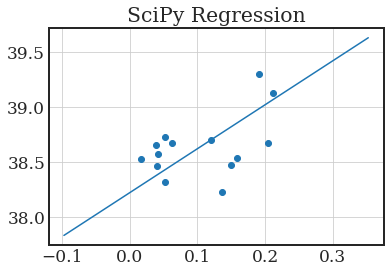

In [13]:
plt.scatter(np.log10(T),lum)
plt.plot(np.log10(x1),np.log10(yfitx3))
plt.title('SciPy Regression')
plt.grid()

In [14]:
#Model 1

with pm.Model() as model1:
    
    #Priors
    
    A1=pm.Normal(name='A1',mu=0,sigma=50)  #Constant A
    
    sigma = pm.HalfNormal("sigma", sigma=10)  #Standard deviation
        
    #Posterior
    
    Lum=np.log10(4*np.pi)+A1+2*np.log10(d)+4*np.log10(T) #Decimal logarithm luminosity formula 
    
    #Likelihood
    
    Y_obs=pm.Normal('Y_obs',Lum,sigma,observed=lum)  #lum is our luminosity data but in logarithmic scale
    
    # Prior sampling, trace definition and posterior sampling
    trace= pm.sample(draws=200000,chains=4,tune=100000,return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, A1]


Sampling 4 chains for 100_000 tune and 200_000 draw iterations (400_000 + 800_000 draws total) took 150 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'A1'}>,
        <AxesSubplot:title={'center':'A1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

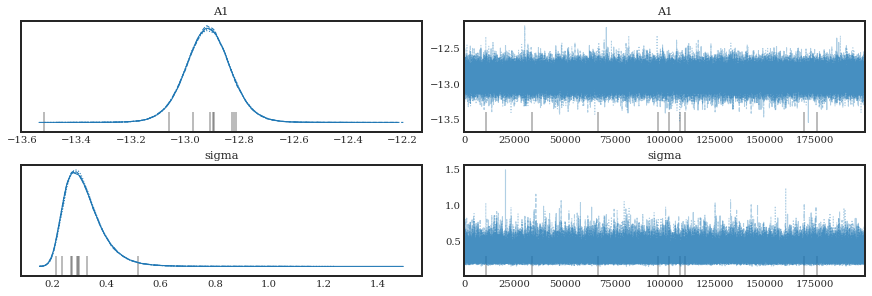

In [15]:
import arviz as az
az.plot_trace(trace)

/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


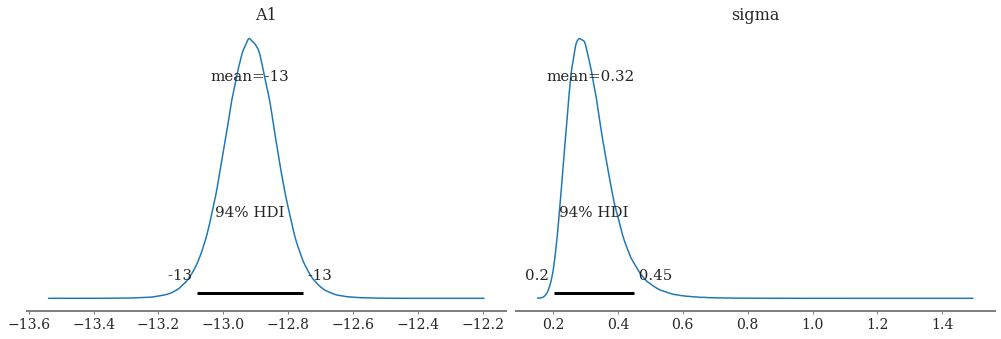

In [16]:
from arviz import plot_posterior

plot_posterior(trace);


> ### Regresion with bayesian model

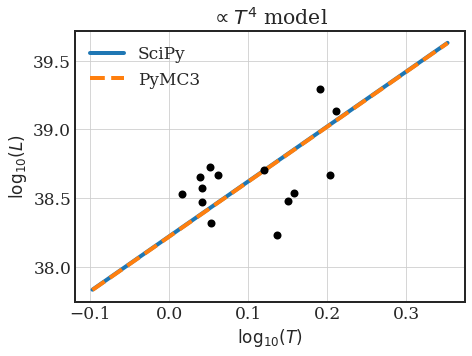

In [17]:

plt.figure(figsize=(7,5))
x_p=np.linspace(0.8,2.25,500)

y_p=10**(np.log10(4*np.pi)+trace['A1'].mean()+2*np.log10(d)+4*np.log10(x_p))

Lum=np.log10(4*np.pi)+A1+2*np.log10(d)+4*np.log10(T)


plt.plot(np.log10(x1),np.log10(yfitx3),label='SciPy',linewidth=4) #scipy
plt.plot(np.log10(x_p),np.log10(y_p),linestyle='dashed',label='PyMC3',linewidth=4) #bayes
plt.scatter(np.log10(T),lum,color='k',zorder=3,linewidth=2)
#plt.fill_between(np.log10(x1),np.log10(yfitx3-covs[0]),np.log10(yfitx3+covs[0]),alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('$\log_{10}(T)$')
plt.ylabel('$\log_{10}(L)$')
plt.title('$\propto T^4$ model')
plt.grid()




/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


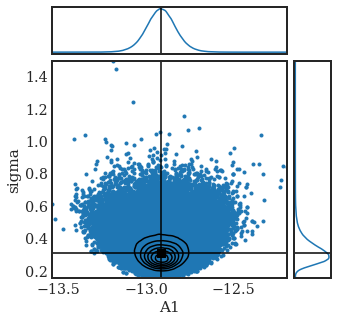

In [18]:
ax = az.plot_pair(
    trace,
    var_names=["A1", "sigma"],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(5, 5),
)

plt.show()

In [19]:
pm.model_to_graphviz(model1)

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/alba/my_env/lib/python3.8/site-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


<AxesSubplot:xlabel='A1', ylabel='sigma'>

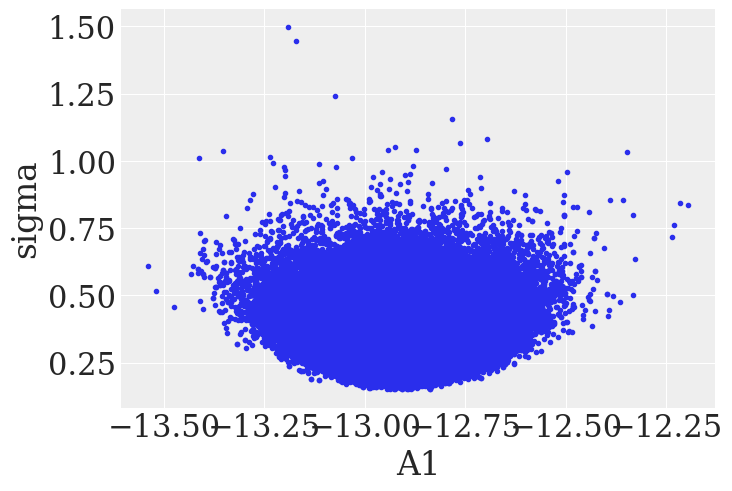

In [20]:

az.style.use("arviz-darkgrid")

az.plot_pair(
   trace, var_names=["A1", "sigma"], divergences=True, textsize=22
)

In [21]:
pm.model_to_graphviz(model1)

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

- ### Modelo 2  $\propto T^2$



In [22]:
#Model 2

with pm.Model() as model2:
    
    #Priors
    
    B1=pm.Normal(name='B1',mu=0,sigma=50) #cambia mucho con el valor inicial de mu y sd
    
    sigma = pm.HalfNormal("sigma", sigma=10)
        
    #Posterior
    
    Lum=np.log10(4*np.pi)+B1+2*np.log10(d)+2*np.log10(T)
    
    #Verosimilitud
    
    Y_obs=pm.Normal('Y_obs',Lum,sigma,observed=lum)
    
    # Prior sampling, trace definition and posterior sampling
    trace1= pm.sample(draws=200000,chains=4,tune=100000,return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, B1]


Sampling 4 chains for 100_000 tune and 200_000 draw iterations (400_000 + 800_000 draws total) took 152 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


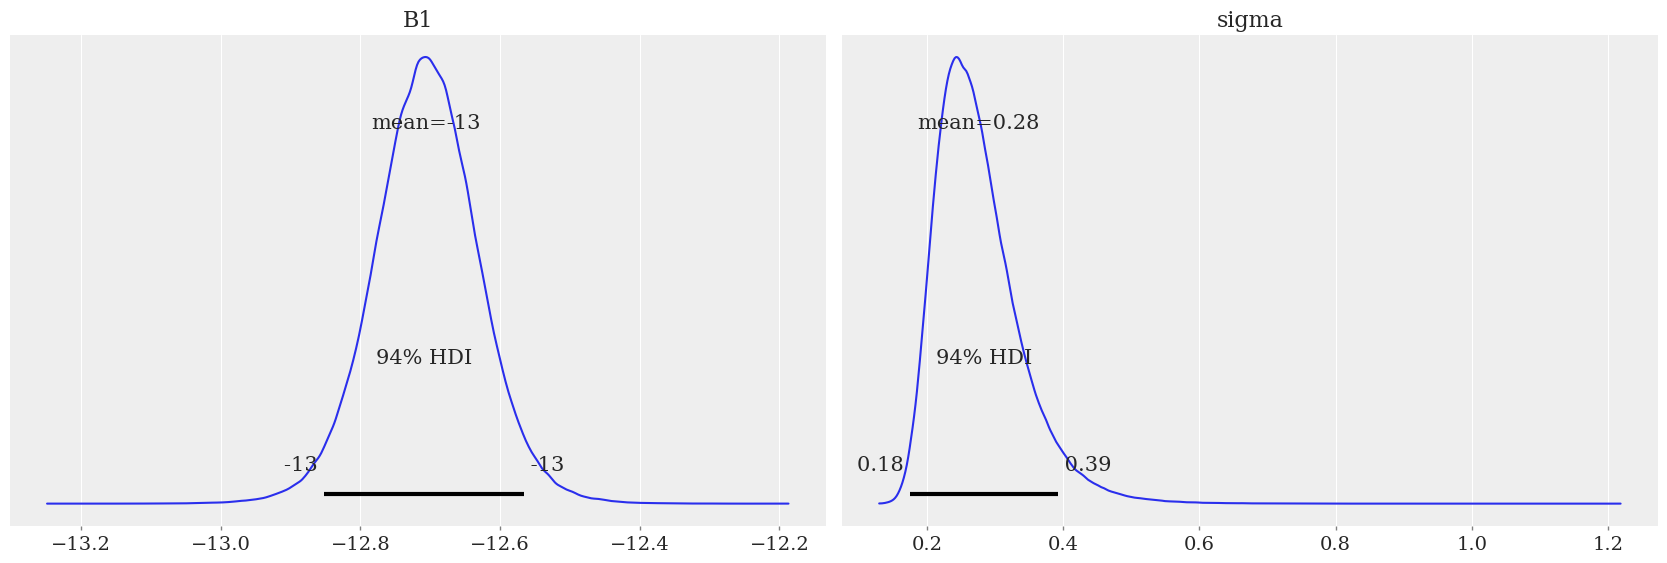

In [23]:
from arviz import plot_posterior

plot_posterior(trace1);


In [24]:
#Fit 2
x2=np.linspace(0.8,2.5,10000)

def func(x, B):
    return B*4*np.pi*d**2*x**2

params, covs = curve_fit(func,wX3_both['Th'],wX3_both['Luminosity_h'])
B = params[0] #boltzmann constant
yfitx2 = B*4*np.pi*d**2*x1**2

print('B =', B)

B = 2.503999134453648e-13


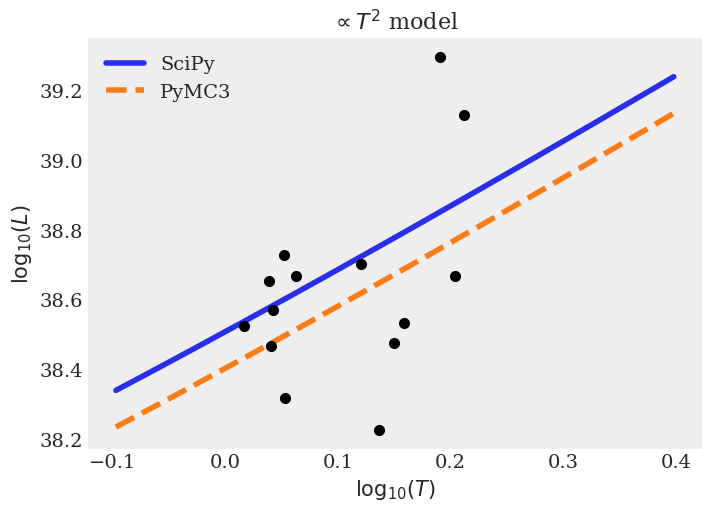

In [25]:
plt.figure(figsize=(7,5))

x_p2=np.linspace(0.8,2.5,500)

y_p2=10**(np.log10(4*np.pi)+trace1['B1'].mean()+2*np.log10(d)+2*np.log10(x_p))

plt.plot(np.log10(x2),np.log10(yfitx2),label='SciPy',linewidth=4) #scipy
plt.plot(np.log10(x_p2),np.log10(y_p2),linestyle='dashed',label='PyMC3',linewidth=4) #bayes
plt.scatter(np.log10(T),lum,color='k',zorder=3,linewidth=2)
#plt.fill_between(np.log10(x1),np.log10(yfitx3-covs[0]),np.log10(yfitx3+covs[0]),alpha=0.2)
plt.legend(loc='upper left')
plt.xlabel('$\log_{10}(T)$')
plt.ylabel('$\log_{10}(L)$')
plt.title('$\propto T^2$ model')
plt.grid()




/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


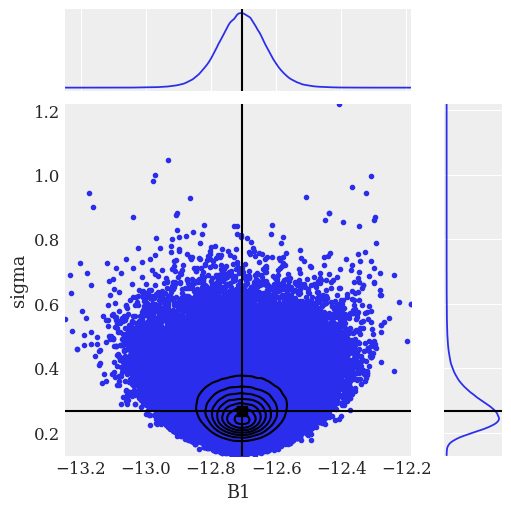

In [26]:
ax = az.plot_pair(
    trace1,
    var_names=["B1", "sigma"],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(5, 5),
)

plt.show()

/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'A1\n0'}>,
        <AxesSubplot:title={'center':'A1\n1'}>,
        <AxesSubplot:title={'center':'A1\n2'}>,
        <AxesSubplot:title={'center':'A1\n3'}>],
       [<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'sigma\n2'}>,
        <AxesSubplot:title={'center':'sigma\n3'}>]], dtype=object)

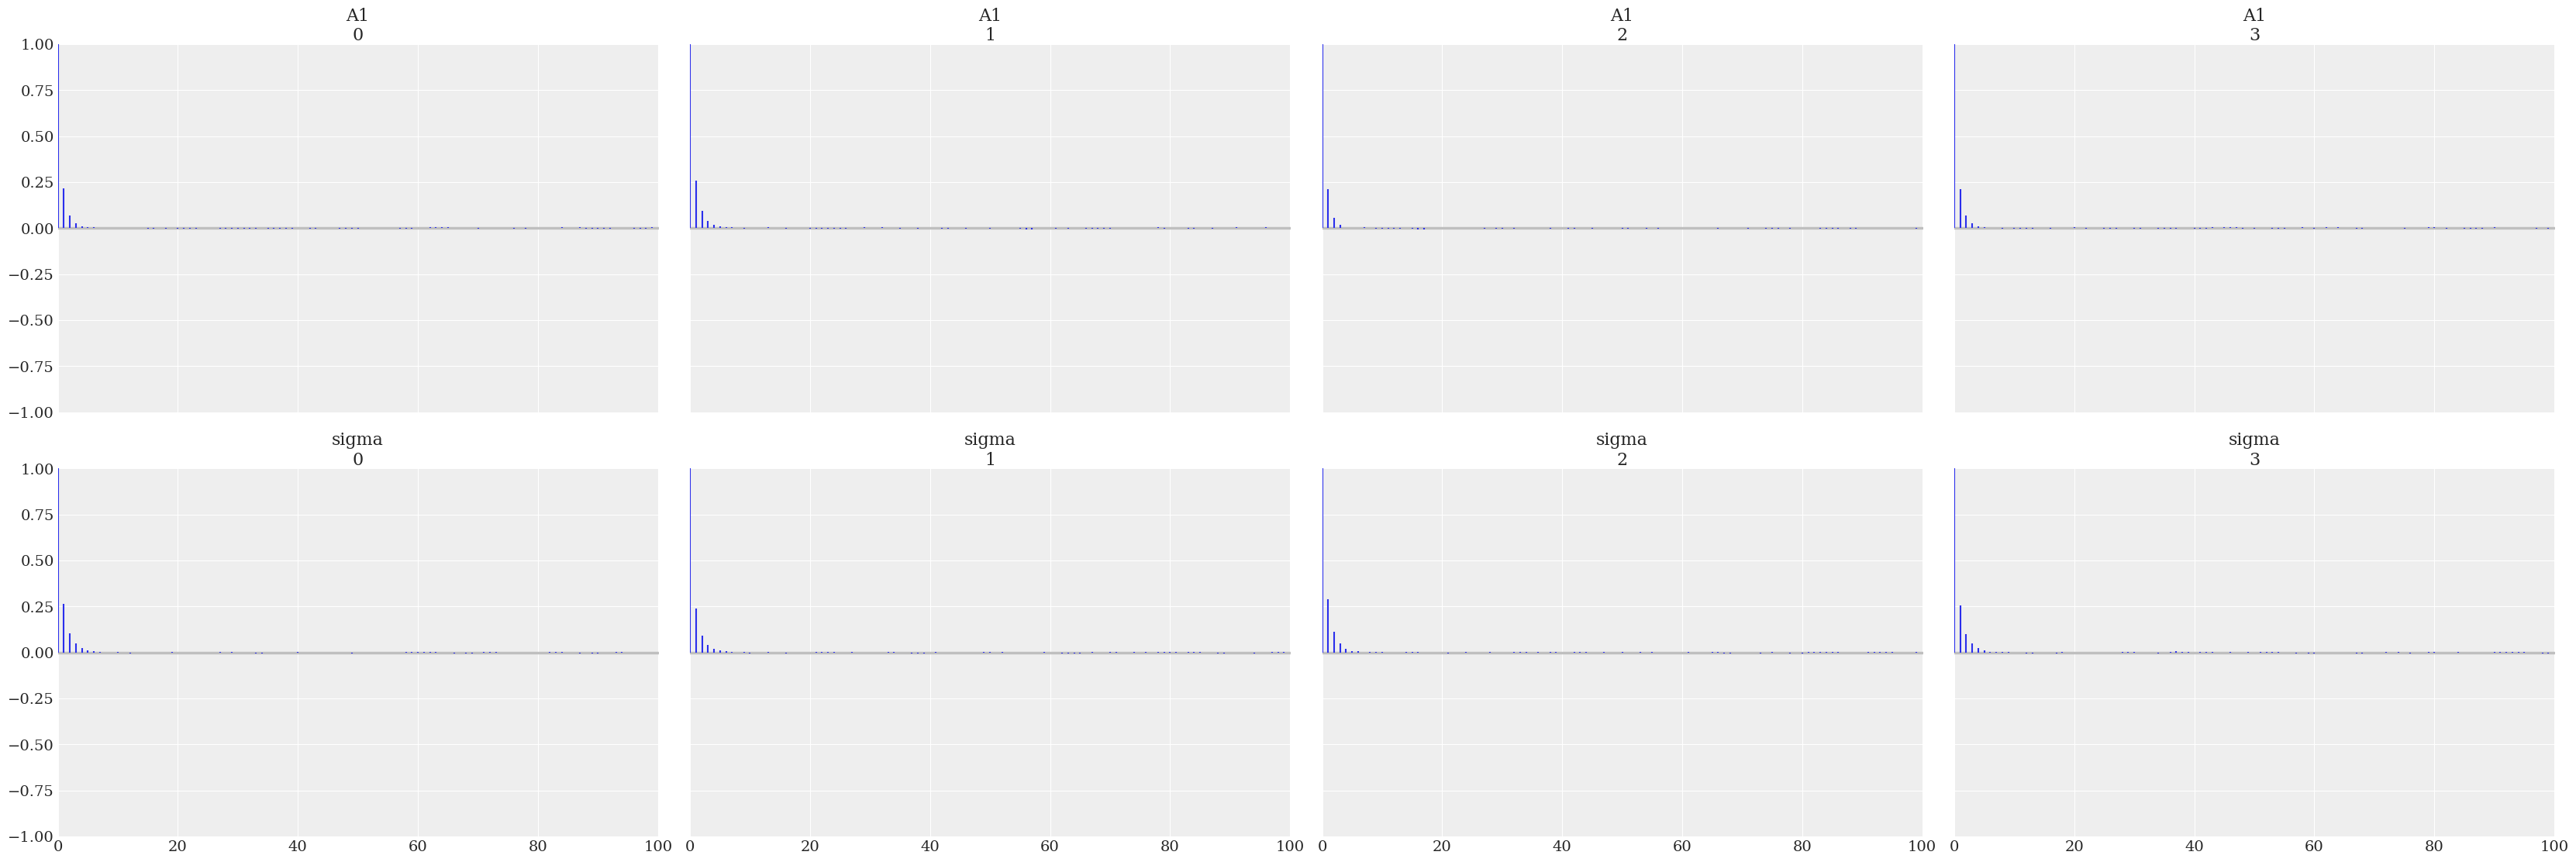

In [27]:

az.plot_autocorr(trace, var_names=("A1", "sigma"))


- ## Comparación de los dos modelos

In [28]:
model1.name = 'model1'
model2.name = 'model2'

In [29]:
df_comp_loo=pm.compare({model1.name: trace, model2.name: trace1})

/Users/alba/my_env/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/alba/my_env/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/alba/my_env/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/alba/my_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:

In [30]:
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2,0,-2.081528,1.755562,0.000000,0.92206,2.470521,0.000000,False,log
model1,1,-3.776092,1.388742,1.694564,0.07794,1.787397,1.849108,False,log


<Figure size 4000x1000 with 0 Axes>

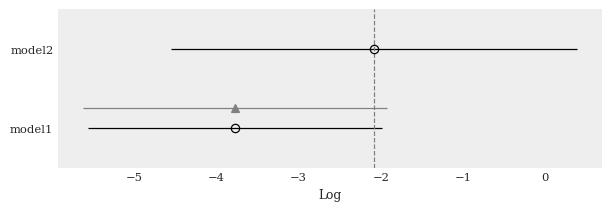

In [31]:
plt.figure(figsize=(40,10))
az.plot_compare(df_comp_loo, insample_dev=False);
plt.grid()